In [94]:
import warnings
import glob
import re
import numpy as np
import pandas as pd
from Bio.PDB.Polypeptide import one_to_three
from pyCodeLib import *
warnings.filterwarnings('ignore')


# sys.path.insert(0, MYHOME)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
plt.rcParams['figure.figsize'] = [16.18033, 10]

In [90]:
pre = "/Users/weilu/Research/optimization/mediated_term/multisequenceanddcafrustratometry/"
a = "3J4RC_277-371_filtered_0.05.seqs"
# a = "3GL5A_2-207_filtered_0.05.seqs"
with open(pre+a) as f:
    all_lines = f.readlines()
n = len(all_lines[0].strip())
n

95

In [95]:
def compute_average_sequence_and_sequence_entropy(multiple_sequence_file, tm_only=False):
	sequences = read_column_from_file(multiple_sequence_file, 1, header_comment_syntax=">")

	if tm_only:
		tm = read_column_from_file(os.path.join(tm_root_directory, multiple_sequence_file.split('.')[0]+'.tm'), 1)
		tm_indices = [i for i, x in enumerate(tm) if x == '2']
		for i, sequence in enumerate(sequences):
			sequences[i] = [sequence[j] for j in tm_indices]

	number_of_sequences = len(sequences)
	sequence_length = len(sequences[0])

	counts_matrix = np.zeros(shape=(20,sequence_length))
	for sequence in sequences:
		aa_index = 0
		for aa in sequence:
			if aa in sequence_entropy_amino_acids:
				counts_matrix[sequence_entropy_amino_acids[aa]][aa_index] += 1
			aa_index += 1

	frequency_matrix = np.zeros(shape=(20,sequence_length))
	for i in range(20):
		for j in range(sequence_length):
			frequency_matrix[i][j] = counts_matrix[i][j]/number_of_sequences

	sequence_entropy = np.zeros(shape=(sequence_length))
	for i in range(sequence_length):
		temp_sum = 0.0
		for j in range(20):
			if frequency_matrix[j][i] != 0:
				sequence_entropy[i] += -frequency_matrix[j][i]*np.log(frequency_matrix[j][i])

	return frequency_matrix, sequence_entropy, number_of_sequences, sequence_length, np.mean(sequence_entropy)

In [9]:
def read_gamma(gammaFile):
    data = np.loadtxt(gammaFile)
    gamma_direct = data[:210]
    gamma_mediated = data[210:]
    return gamma_direct, gamma_mediated
def readGammas(gammaFile):
    gamma_direct, gamma_mediated = read_gamma(gammaFile)
    gamma_ijm = np.zeros((20, 20))
    water_gamma_ijm = np.zeros((20, 20))
    protein_gamma_ijm = np.zeros((20, 20))

    count = 0
    for i in range(20):
        for j in range(i, 20):
            gamma_ijm[i][j] = gamma_direct[count][0]
            gamma_ijm[j][i] = gamma_direct[count][0]
            count += 1
    count = 0
    for i in range(20):
        for j in range(i, 20):
            water_gamma_ijm[i][j] = gamma_mediated[count][1]
            water_gamma_ijm[j][i] = gamma_mediated[count][1]
            count += 1
    count = 0
    for i in range(20):
        for j in range(i, 20):
            protein_gamma_ijm[i][j] = gamma_mediated[count][0]
            protein_gamma_ijm[j][i] = gamma_mediated[count][0]
            count += 1
    return gamma_ijm, protein_gamma_ijm, water_gamma_ijm
gamma_se_map_1_letter = {   'A': 0,  'R': 1,  'N': 2,  'D': 3,  'C': 4,
                            'Q': 5,  'E': 6,  'G': 7,  'H': 8,  'I': 9,
                            'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14,
                            'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19}

In [8]:
gamma_ijm, protein_gamma_ijm, water_gamma_ijm = readGammas("/Users/weilu/Research/optimization/mediated_term/gamma.dat")



In [20]:
burialGamma = np.loadtxt(pre+"../burial_gamma.dat")

In [35]:
all_lines[0].strip()

'EKIYKDGERIIAQGEKADSFYIIESGEVSILIRSKTKSNKNGGNQEVKVAECKPGNSFGELALMYGHPRAATVLAIEPSTLWSLDRITFRTIIGP'

In [91]:
table_gamma = np.zeros((n, n))
table_protein_gamma = np.zeros((n, n))
table_water_gamma = np.zeros((n, n))
count = 0
for line in all_lines:
    line = line.strip()
    if "X" in line or "U" in line:
        continue
    else:
        count += 1
        if count % 100 == 0:
            print(count)
        if count > 1:
            break
    for i, r1 in enumerate(line):
        res1 = gamma_se_map_1_letter[r1]
        for j, r2 in enumerate(line):
            res2 = gamma_se_map_1_letter[r2]
            table_gamma[i][j] += gamma_ijm[res1][res2]
            table_protein_gamma[i][j] += protein_gamma_ijm[res1][res2] 
            table_water_gamma[i][j] += water_gamma_ijm[res1][res2]

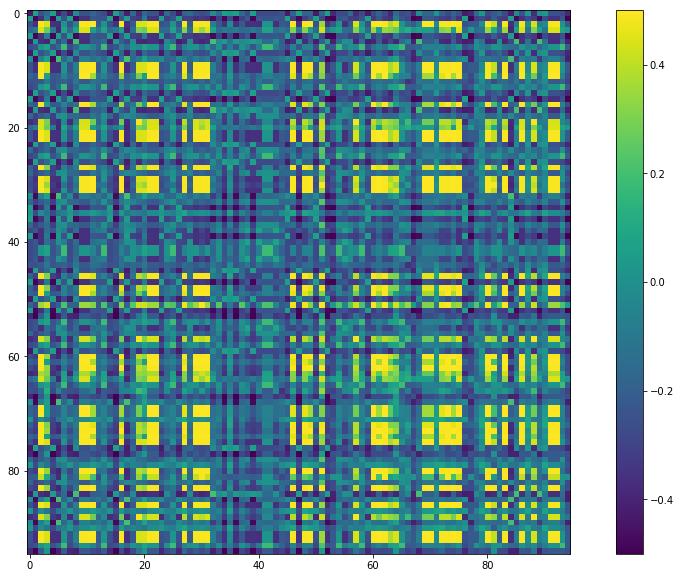

In [92]:
plt.imshow(table_gamma/count)
plt.colorbar()

In [85]:
contact = pd.read_csv(pre+"../contact.csv")
contact.columns = contact.columns.str.strip()
native_contact_map = np.zeros((n+4,n+4))
for index, row in contact.iterrows():
#     print(row)
    i = int(row["i"]) - 2
    j = int(row["j"]) - 2
    native_contact_map[i][j] = float(row["Distance"])


In [97]:
# Order to be consistent with AWSEM
sequence_entropy_amino_acids = {
	'A':0,
	'P':1,
	'K':2,
	'N':3,
	'R':4,
	'F':5,
	'D':6,
	'Q':7,
	'E':8,
	'G':9,
	'I':10,
	'H':11,
	'L':12,
	'C':13,
	'M':14,
	'S':15,
	'T':16,
	'Y':17,
	'V':18,
	'W':19
}

valid_amino_acid_types = ['A', 'P', 'K', 'N', 'R', 'F', 'D', 'Q', 'E', 'G', 'I', 'H', 'L', 'C', 'M', 'S', 'T', 'Y', 'V', 'W']


In [99]:
frequency_matrix, sequence_entropy, number_of_sequences, sequence_length, mean_seq_entropy = compute_average_sequence_and_sequence_entropy("/Users/weilu/Research/optimization/mediated_term/multisequenceanddcafrustratometry/3J4RC_277-371_filtered_0.05.seqs")


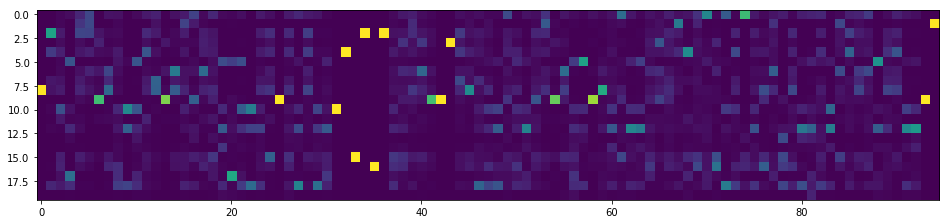

In [103]:
plt.imshow(frequency_matrix)
# plt.colorbar()

In [104]:
hydrophobicity_map = dict(list(zip(hydrophobicity_letters, list(range(20)))))

In [105]:
hydrophobicity_map

{'R': 0,
 'K': 1,
 'N': 2,
 'Q': 3,
 'D': 4,
 'E': 5,
 'H': 6,
 'Y': 7,
 'W': 8,
 'S': 9,
 'T': 10,
 'G': 11,
 'P': 12,
 'A': 13,
 'M': 14,
 'C': 15,
 'F': 16,
 'L': 17,
 'V': 18,
 'I': 19}

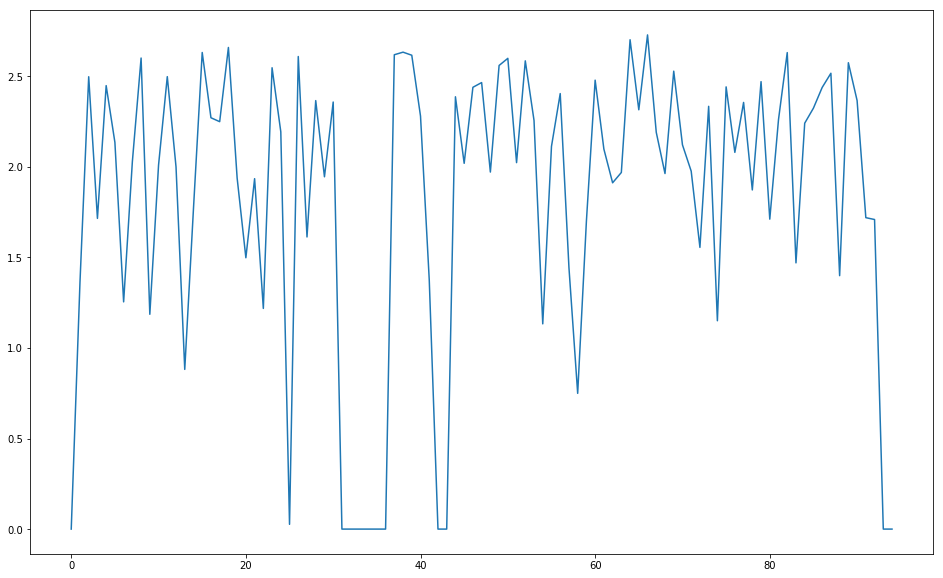

In [100]:
plt.plot(sequence_entropy)

In [64]:
count = 0
for line in all_lines:
    line = line.strip()
    if "X" in line:
        continue
    else:
        count += 1
        if count % 100 == 0:
            print(count)
        if count > 1e4:
            break
    for i, r1 in enumerate(line):
        res1 = gamma_se_map_1_letter[r1]
        for j, r2 in enumerate(line):
            res2 = gamma_se_map_1_letter[r2]
            table_gamma[i][j] += gamma_ijm[res1][res2]
            table_protein_gamma[i][j] += protein_gamma_ijm[res1][res2] 
            table_water_gamma[i][j] += water_gamma_ijm[res1][res2]

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


In [65]:
count

10001

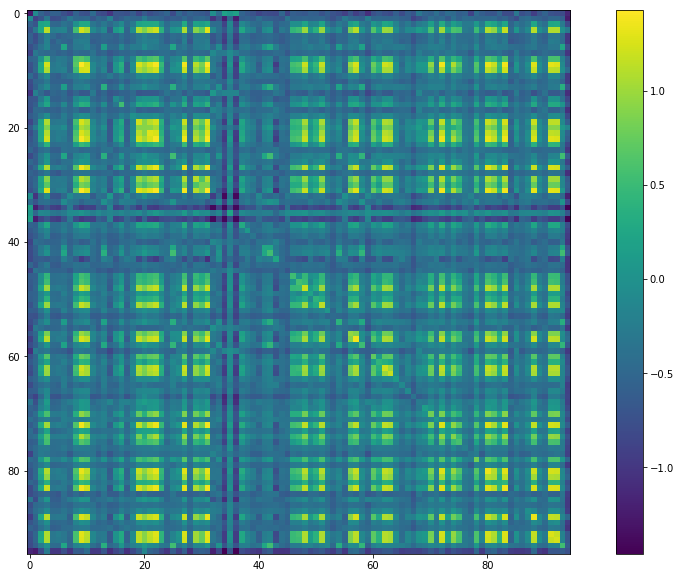

In [66]:
plt.imshow(table_gamma/count)
plt.colorbar()

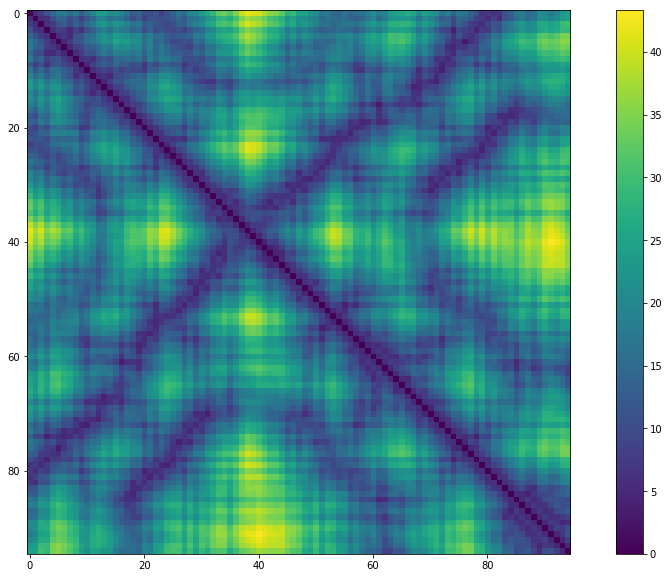

In [74]:
plt.imshow(native_contact_map)
plt.colorbar()

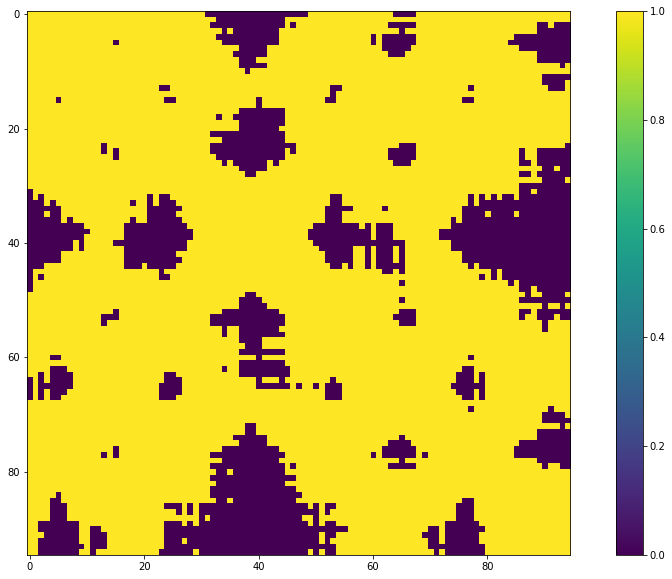

In [73]:
plt.imshow((native_contact_map < 25).astype(int))
plt.colorbar()

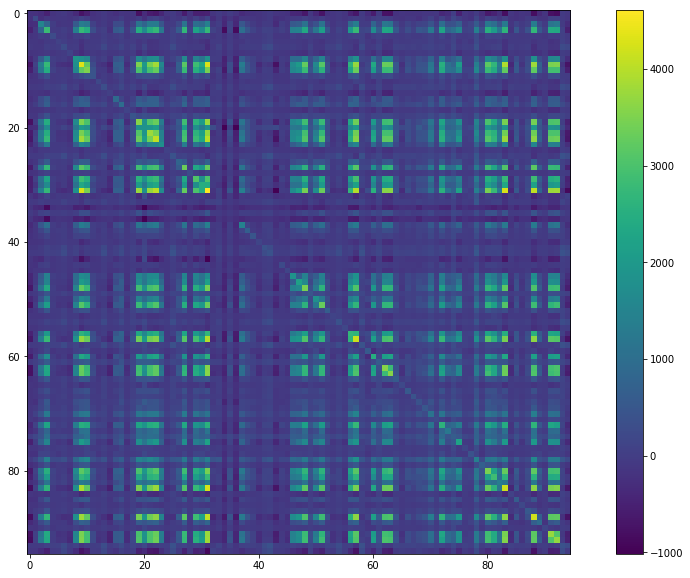

In [62]:
plt.imshow(table_protein_gamma)
plt.colorbar()

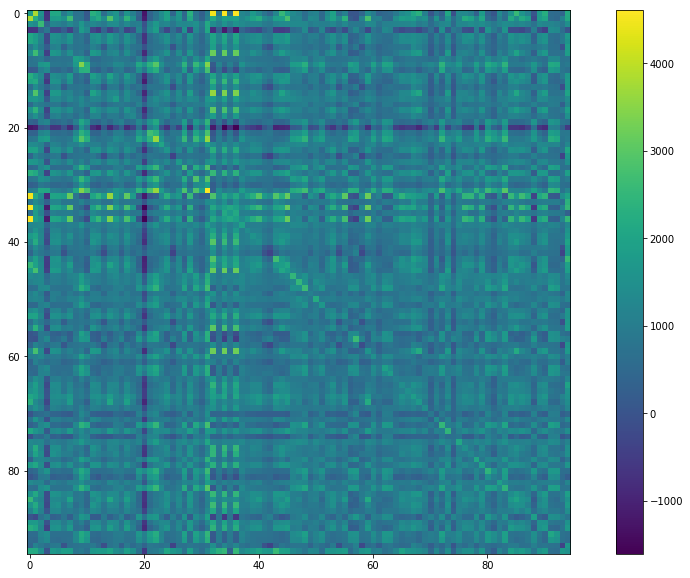

In [63]:
plt.imshow(table_water_gamma)
plt.colorbar()

In [43]:
contact = pd.read_csv(pre+"../contact.csv")
contact.columns = contact.columns.str.strip()
native_contact_map = np.zeros((n,n))
for index, row in contact.iterrows():
#     print(row)
    i = int(row["i"]) - 277
    j = int(row["j"]) - 277
    native_contact_map[i][j] = float(row["Distance"])




In [59]:
for index, row in contact.iterrows():
#     print(row)
    i = int(row["i"]) - 277
    j = int(row["j"]) - 277
    native_contact_map[i][j] = float(row["Distance"])


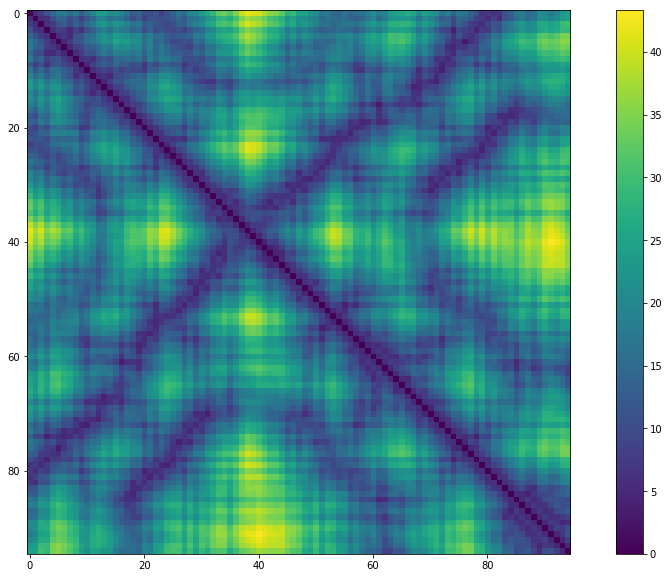

In [61]:
plt.imshow(native_contact_map)
plt.colorbar()

In [5]:
pd.read_table(pre+a, names=["seqs"])

,seqs
0,EKIYKDGERIIAQGEKADSFYIIESGEVSILIRSKTKSNKNGGNQE...
1,EKVFSPGDYICKKGDIGKEMYIINEGKLAVLIRSKTKVADDGGNVT...
2,ERRYPKNQVLFYQWEDAQWIYMPVDGLVVLNIRSKTKYEDNGGNDL...
3,EKIYKDGERIIAQGEKADSFYIIESGEVSILIRSKTKSNKNGGNQE...
4,ERIYLQGEFIIRQGEPGSQIFVLADGKAEVFIRSKTKSQENKGNQE...
5,EVTLARGDSLFHEGDPGDRLYVVTEGKVKLHIRSKTKTSPDGGNRE...
6,ERIYPAGRLLVEAGSPNDTVFRLRKGWVGRLIRSKTKTLEDGGNRS...
7,ERFYQKQEFVFMEGQEREAVYFISKGIIKTSIRSKTKTDRNGGNKE...
8,ERTLTAGESIIWEGEDSVLVANVIDGVLKLSIRSKTKNTEDGGNRE...
9,EKVFSSKEKIIIQGKYVPSIFIVKSGIVKCYIRSKTKNEDNGGNRD...
